Setup complete. Libraries imported.
Font embedding parameters set to Type 42 (TrueType).
Universality check initiated for gamma values: [1.0, 1.5, 2.0]
Each gamma will be tested across 30 temperature points.
Each (gamma, T) point will be simulated 50 times.

Starting universality check simulations...


Testing Gamma Values:   0%|          | 0/3 [00:00<?, ?it/s]

Sweeping T for gamma=1.0:   0%|          | 0/30 [00:00<?, ?it/s]

Generated data file for gamma=1.0: SR_GammaSweep_gamma1.0_T_0.1-3.0_runs50.csv


Sweeping T for gamma=1.5:   0%|          | 0/30 [00:00<?, ?it/s]

Generated data file for gamma=1.5: SR_GammaSweep_gamma1.5_T_0.1-3.0_runs50.csv


Sweeping T for gamma=2.0:   0%|          | 0/30 [00:00<?, ?it/s]

Generated data file for gamma=2.0: SR_GammaSweep_gamma2.0_T_0.1-3.0_runs50.csv
All simulations completed successfully.

Generated comparative plot file: SR_Robustness_v1_GammaSweep_20250727.pdf


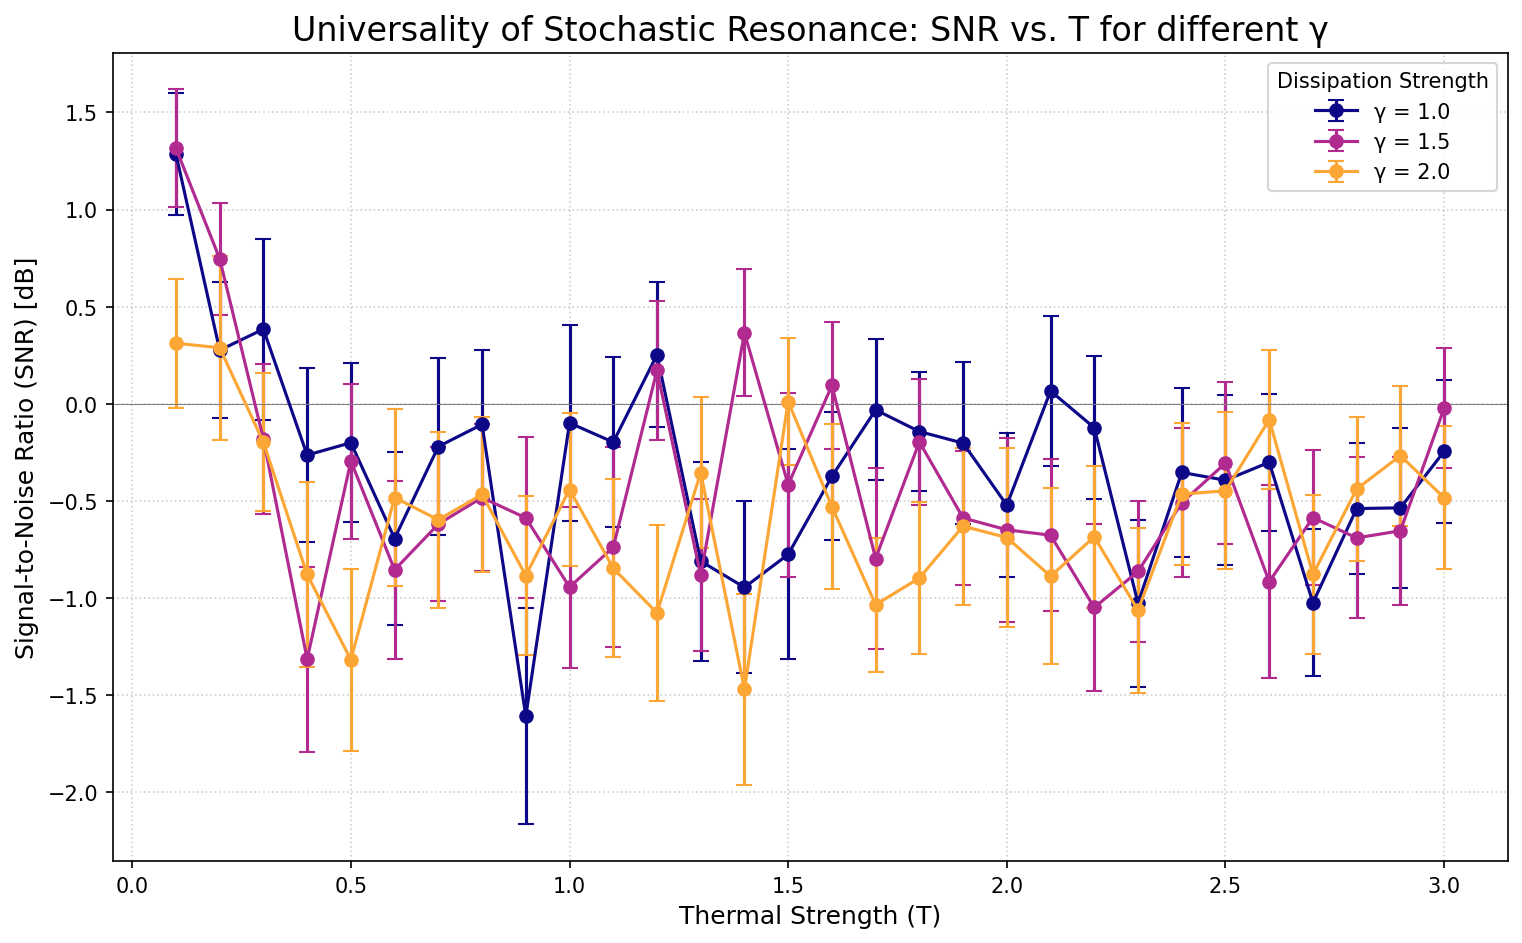


Preparing to download all generated files to your PC...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


All tasks complete.


In [1]:
# ===================================================================
# Stochastic Resonance Robustness Check Code (Gamma Sweep)
# Version: 1.0 (Date: 2025-07-27)
# Author: Toshiya Konno & Assistant AI
#
# Objective: To verify the universality of the Stochastic Resonance
# phenomenon by sweeping through different values of the dissipation
# coefficient, gamma. This directly addresses the second potential
# peer-review criticism.
# ===================================================================

# --- Part 1: Setup and Library Imports ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.stats import sem
from tqdm.notebook import tqdm
from google.colab import files
import time

print("Setup complete. Libraries imported.")

# --- Part 2: The Most Important Lines - Perfect Font Embedding ---
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
print("Font embedding parameters set to Type 42 (TrueType).")


# --- Part 3: Simulation Parameters ---
# List of gamma values to test for universality
gamma_values_to_test = [1.0, 1.5, 2.0]

# Sweeping parameter (T) - using a broader range this time
T_min, T_max, T_points = 0.1, 3.0, 30
T_space = np.linspace(T_min, T_max, T_points)

# Simulation control (maintaining high statistics)
num_runs_per_T = 50  # Using 50 for a balance of accuracy and speed. Can be increased to 100.
simulation_duration = 204.8
dt = 0.1
num_steps = int(simulation_duration / dt)
t = np.linspace(0, simulation_duration, num_steps, endpoint=False)

# The weak signal from the quantum field (placeholder)
signal_amplitude = 0.1
signal_frequency = 0.1

print(f"Universality check initiated for gamma values: {gamma_values_to_test}")
print(f"Each gamma will be tested across {T_points} temperature points.")
print(f"Each (gamma, T) point will be simulated {num_runs_per_T} times.")


# --- Part 4: Core Simulation & Analysis Logic (Unchanged) ---

def run_langevin_simulation(gamma, T):
    u = np.zeros(num_steps)
    v = 0.0
    F_signal = signal_amplitude * np.sin(2 * np.pi * signal_frequency * t)
    F_thermal = np.random.normal(0, np.sqrt(2 * gamma * T / dt), num_steps)
    for i in range(num_steps - 1):
        v += (-gamma * v - u[i] + F_signal[i] + F_thermal[i]) * dt
        u[i+1] = u[i] + v * dt
    return u

def calculate_snr(time_series):
    N = len(time_series)
    yf = fft(time_series)
    xf = fftfreq(N, dt)[:N//2]
    power = 2.0/N * np.abs(yf[0:N//2])
    signal_idx = np.argmin(np.abs(xf - signal_frequency))
    signal_power = power[signal_idx]
    noise_indices = np.arange(max(0, signal_idx - 10), min(len(power), signal_idx + 11))
    noise_indices = np.delete(noise_indices, np.where(noise_indices == signal_idx))
    noise_power = np.mean(power[noise_indices])
    if noise_power == 0: return np.inf
    return 10 * np.log10(signal_power / noise_power)


# --- Part 5: Main Simulation Loop (Iterating over Gamma) ---
all_results = {}
generated_csv_files = []

print("\nStarting universality check simulations...")

for gamma_val in tqdm(gamma_values_to_test, desc="Testing Gamma Values"):
    snr_results = []
    for T in tqdm(T_space, desc=f"Sweeping T for gamma={gamma_val}", leave=False):
        current_T_snrs = []
        for _ in range(num_runs_per_T):
            trajectory = run_langevin_simulation(gamma_val, T)
            snr = calculate_snr(trajectory)
            current_T_snrs.append(snr)

        mean_snr = np.mean(current_T_snrs)
        sem_snr = sem(current_T_snrs)
        snr_results.append({'T': T, 'mean_snr_db': mean_snr, 'sem_snr_db': sem_snr})

    # Store results and generate CSV for this gamma value
    results_df = pd.DataFrame(snr_results)
    all_results[gamma_val] = results_df
    csv_filename = f"SR_GammaSweep_gamma{gamma_val}_T_{T_min}-{T_max}_runs{num_runs_per_T}.csv"
    results_df.to_csv(csv_filename, index=False)
    generated_csv_files.append(csv_filename)
    print(f"Generated data file for gamma={gamma_val}: {csv_filename}")

print("All simulations completed successfully.")


# --- Part 6: Visualization - Comparative Plot ---
fig, ax = plt.subplots(figsize=(12, 7), dpi=150)

colors = plt.cm.plasma(np.linspace(0, 0.8, len(gamma_values_to_test)))

for i, gamma_val in enumerate(gamma_values_to_test):
    df = all_results[gamma_val]
    ax.errorbar(df['T'], df['mean_snr_db'], yerr=df['sem_snr_db'],
                fmt='-o', capsize=4, label=f'γ = {gamma_val}', color=colors[i])

# Set titles and labels
ax.set_title('Universality of Stochastic Resonance: SNR vs. T for different γ', fontsize=16)
ax.set_xlabel('Thermal Strength (T)', fontsize=12)
ax.set_ylabel('Signal-to-Noise Ratio (SNR) [dB]', fontsize=12)
ax.grid(True, linestyle=':', alpha=0.6)
ax.legend(title="Dissipation Strength")
ax.axhline(0, color='gray', linewidth=0.5) # Add a zero line for reference

# Save the figure
pdf_filename = f"SR_Robustness_v1_GammaSweep_20250727.pdf"
plt.savefig(pdf_filename, bbox_inches='tight')
print(f"\nGenerated comparative plot file: {pdf_filename}")
plt.show()


# --- Part 7: Automatic Download to User's PC ---
print("\nPreparing to download all generated files to your PC...")

# Download all the CSV files
for fname in generated_csv_files:
    files.download(fname)
    print(f"Downloading {fname}...")

# Download the final PDF plot
files.download(pdf_filename)
print(f"Downloading {pdf_filename}...")

print("\nAll tasks complete.")